# Example of running sar-pre-processing package

## 1. Requirements

- Installation of SenSARP
- Installation of ESA's SNAP Toolbox version >8.0.3
    - Currently only SNAP version 8.0 can be downloaded from the ESA website (https://step.esa.int/main/download/snap-download/). To update SNAP to a version >8.0.3 please start the SNAP software. You will be asked if you want to search for update. After the updates are installed you need to restart SNAP to initialize the installed updates.
    - SNAP Toolbox need libgfortran for specific operations but currently libgfortran is not installed during the installation process of SNAP therefore you might use ```sudo apt-get install gfortran```

- Sentinel-1 SLC data
    - Instruction how to download Sentinel 1 data are given in Section 2

## 2. Download sample data from Sentinel Data Hub
### Option 1: Download data from Sentinel Data Hub via python package sentinelsat

 <span style="color:red">Create Account (https://scihub.copernicus.eu/dhus/#/self-registration) and change user and password below</span>.

In [1]:
# connect to the API
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
user = 'user'
password = 'password'
# initialize settings
api = SentinelAPI(user, password)

Search for available data

In [2]:
# search by polygon (MNI test site coordinates), time, and SciHub query keywords
footprint = geojson_to_wkt(read_geojson('coordinates_mni.geojson'))
products = api.query(footprint,
                     date=('20210501', '20210503'),
                     platformname='Sentinel-1',
                     producttype='SLC')
print('Following products will be downloaded')
print(api.to_dataframe(products).title.values)

print('These {} product need {} Gb of disk space'.format(len(products), api.get_products_size(products)))

Following products will be downloaded
['S1B_IW_SLC__1SDV_20210502T051747_20210502T051814_026721_03311D_1954'
 'S1A_IW_SLC__1SDV_20210501T052625_20210501T052653_037690_04727A_7606']
These 2 product need 15.36 Gb of disk space


Start download process (**<span style="color:red">Attention: might take a while and data will requries some free disk space</span>)**

In [3]:
# download all results from the search
# files will be downloaded to specified path
import os
path = "/home/test/Desktop/data2"
try:
    os.makedirs(path)
except: FileExistsError
api.download_all(products, path)

ResultTuple(downloaded={'11ccf12c-bcec-4a46-8c53-da625bbcd58c': {'id': '11ccf12c-bcec-4a46-8c53-da625bbcd58c', 'title': 'S1A_IW_SLC__1SDV_20210501T052625_20210501T052653_037690_04727A_7606', 'size': 4702733848, 'md5': 'df1d4439566a356edcdd9348d5c4f64a', 'date': datetime.datetime(2021, 5, 1, 5, 26, 25, 916000), 'footprint': 'POLYGON((12.719948 47.890640,9.287650 48.291550,9.677358 49.963444,13.229255 49.560886,12.719948 47.890640))', 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('11ccf12c-bcec-4a46-8c53-da625bbcd58c')/$value", 'Online': True, 'Creation Date': datetime.datetime(2021, 5, 1, 7, 53, 0, 857000), 'Ingestion Date': datetime.datetime(2021, 5, 1, 7, 45, 50, 840000), 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('11ccf12c-bcec-4a46-8c53-da625bbcd58c')/Products('Quicklook')/$value", 'path': '/home/test/Desktop/data2/S1A_IW_SLC__1SDV_20210501T052625_20210501T052653_037690_04727A_7606.zip', 'downloaded_bytes': 0}, '38fc59bc-26fe-4359-ad17-fb

### Option 2: Download data from NASA Earth Data Search

You can search for Sentinel-1 data at <https://search.earthdata.nasa.gov/search>`_.
Instructions how to search and download data from NASA Earth Data can be found `here <https://earthdata.nasa.gov/faq/earthdata-search-faq>`_.

## 3. Use sar-pre-processing package to process Sentinel-1 SLC data

Set paths for
- input_folder (path to stored Sentinel-1 SLC data (zip files) e.g. "~/Downloads")
- output_folder (path where processed data will be stored e.g. "~/output")
- gpt_loction (gpt is located in the bin folder of your SNAP installation)' 

In [8]:
input_folder = os.path.expanduser(path)
output_folder = os.path.expanduser(path)
gpt_location = os.path.expanduser('~/snap/bin/gpt')

Create config file with information about input, output and gpt location

In [9]:
import yaml

with open('sample_config_file.yaml') as stream:
   data = yaml.safe_load(stream)

data['input_folder'] = input_folder
data['output_folder'] = output_folder
data['gpt'] = gpt_location

with open('test_config_file.yaml', 'wb') as stream:
   yaml.safe_dump(data, stream, default_flow_style=False, 
                  explicit_start=True, allow_unicode=True, encoding='utf-8')

Optional config options which might be useful

In [10]:
with open('test_config_file.yaml') as stream:
   data = yaml.safe_load(stream)

# Filter option
## Filter via year of interes
data['year'] = '2021'

## Define region of interest
data['region']['lr']['lat'] = 48.2 # lower right latitude
data['region']['lr']['lon'] = 11.9 # lower right longitude
data['region']['ul']['lat'] = 48.4 # upper left latitude
data['region']['ul']['lon'] = 11.6 # upper left longitude
data['region']['subset'] = 'yes'

## Define multi-temporal filtering properties
data['speckle_filter']['multi_temporal']['apply'] = 'yes'
data['speckle_filter']['multi_temporal']['files'] = '5' # Number of files used for multi temporal filtering

## Define incidence angle for normalization
data['normalization_angle'] = '35'

with open('test_config_file.yaml', 'wb') as stream:
   yaml.safe_dump(data, stream, default_flow_style=False, 
                  explicit_start=True, allow_unicode=True, encoding='utf-8')

Start pre-processing steps

In [11]:
from sar_pre_processing.sar_pre_processor import *
import warnings
warnings.filterwarnings("ignore")

processing = SARPreProcessor(config='test_config_file.yaml')
processing.create_processing_file_list()
print('start step 1')
processing.pre_process_step1()
print('start step 2')
processing.pre_process_step2()
print('start step 3')
processing.pre_process_step3()
print('start add netcdf information')
processing.add_netcdf_information()
print('start create netcdf stack')
processing.create_netcdf_stack()

INFO:root:Found files within input folder: 11
INFO:root:Number of found files for year 2021: 11
INFO:root:area of interest not specified
INFO:root:Number of found files that were double processed: 0.0
INFO:root:Number of found files with border issues: 6
INFO:root:area of interest specified
INFO:root:normalisation angle not specified, default value of 35 is used for processing
INFO:ComponentProgress:0
INFO:ComponentProgress:0
INFO:root:Process S1A_IW_SLC__1SDV_20210508T051817_20210508T051845_037792_0475E2_BB6F.zip with SNAP.


start step 1


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/05


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-05-01T00:00:000Z TO 2021-05-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-04-01T00:00:000Z TO 2021-04-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.


Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/05


....11%....23%....34%....46%....57%....69%....80%.... done.


INFO:root:0
INFO:ComponentProgress:9
INFO:ComponentProgress:9
INFO:root:Process S1A_IW_SLC__1SDV_20210509T170731_20210509T170758_037814_04768F_E55C.zip with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/05


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-05-01T00:00:000Z TO 2021-05-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-04-01T00:00:000Z TO 2021-04-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.


Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/05


....10%....21%....32%....42%....53%....64%....75%....85%.. done.


INFO:root:0
INFO:ComponentProgress:18
INFO:ComponentProgress:18
INFO:root:Process S1B_IW_SLC__1SDV_20210502T051747_20210502T051814_026721_03311D_1954.zip with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


SEVERE: org.esa.snap.core.dataio.ProductIO: Error attempting to read /home/test/Desktop/data2/S1B_IW_SLC__1SDV_20210502T051747_20210502T051814_026721_03311D_1954.zip with plugin reader org.esa.s2tbx.dataio.s2.ortho.plugins.Sentinel2L1CProduct_Multi_UTM22N_ReaderPlugIn@51d387d3
java.lang.IllegalStateException: java.lang.reflect.InvocationTargetException
	at org.esa.s2tbx.dataio.VirtualDirEx.build(VirtualDirEx.java:101)
	at org.esa.s2tbx.dataio.s2.filepatterns.S2NamingConventionUtils.transformToSentinel2VirtualPath(S2NamingConventionUtils.java:306)
	at org.esa.s2tbx.dataio.s2.ortho.S2ProductCRSCache$S2ProductCRSCacheEntry.<init>(S2ProductCRSCache.java:57)
	at org.esa.s2tbx.dataio.s2.ortho.S2ProductCRSCache.ensureIsCached(S2ProductCRSCache.java:155)
	at org.esa.s2tbx.dataio.s2.ortho.S2OrthoProductReaderPlugIn.getDecodeQualification(S2OrthoProductReaderPlugIn.java:101)
	at org.esa.snap.core.dataio.ProductIO.getProductReaderForInput(ProductIO.java:301)
	at org.esa.snap.core.gpf.common.ReadO

 done.


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1B/2021/05


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-05-01T00:00:000Z TO 2021-05-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-04-01T00:00:000Z TO 2021-04-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.


Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1B/2021/05


...12%...24%..34%...46%...58%..68%...80%... done.


INFO:root:0
INFO:ComponentProgress:36
INFO:ComponentProgress:36
INFO:root:Process S1B_IW_SLC__1SDV_20210507T052559_20210507T052626_026794_033365_83ED.zip with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1B/2021/05


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-05-01T00:00:000Z TO 2021-05-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-04-01T00:00:000Z TO 2021-04-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.


Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1B/2021/05


...11%...21%...32%...43%...53%...64%...75%...85%.. done.


INFO:root:0
INFO:ComponentProgress:45
INFO:ComponentProgress:45
INFO:root:Process S1A_IW_SLC__1SDV_20210501T052625_20210501T052653_037690_04727A_7606.zip with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/05


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-05-01T00:00:000Z TO 2021-05-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-04-01T00:00:000Z TO 2021-04-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.


Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/05


...10%...20%...30%....42%...52%...62%...72%...82%... done.


INFO:root:0
INFO:ComponentProgress:54
INFO:ComponentProgress:54
INFO:root:Process S1A_IW_SLC__1SDV_20210504T165914_20210504T165941_037741_04743F_EC6E.zip with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/05


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-05-01T00:00:000Z TO 2021-05-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-04-01T00:00:000Z TO 2021-04-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.


Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/05


...10%...20%...30%....42%...52%...62%...72%...82%... done.


INFO:root:0
INFO:ComponentProgress:63
INFO:ComponentProgress:63
INFO:root:Process S1B_IW_SLC__1SDV_20210510T165830_20210510T165858_026845_0334F9_4E51.zip with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1B/2021/05


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-05-01T00:00:000Z TO 2021-05-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-04-01T00:00:000Z TO 2021-04-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.


Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1B/2021/05


...11%...23%...34%...45%..55%...66%...78%...90% done.


INFO:root:0
INFO:root:skip processing for /home/test/Desktop/data2/S1B_IW_SLC__1SDV_20210502T051747_20210502T051814_026721_03311D_1954.zip. File does not exist
INFO:root:skip processing for /home/test/Desktop/data2/S1A_IW_SLC__1SDV_20210501T052651_20210501T052718_037690_04727A_B474.zip. File does not exist
INFO:root:skip processing for /home/test/Desktop/data2/S1A_IW_SLC__1SDV_20210504T165938_20210504T170006_037741_04743F_5C00.zip. File does not exist
INFO:root:skip processing for /home/test/Desktop/data2/S1B_IW_SLC__1SDV_20210510T165856_20210510T165923_026845_0334F9_434F.zip. File does not exist
INFO:ComponentProgress:0
INFO:ComponentProgress:0
INFO:root:Scene 1 of 7
INFO:root:Process S1A_IW_SLC__1SDV_20210501T052625_20210501T052653_037690_04727A_7606_GC_RC_No_Su.dim with SNAP.


start step 2


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...12%...25%..35%..45%...57%..67%..77%...89%

-- org.jblas INFO Deleting /tmp/jblas16272820038366902/libquadmath-0.so
-- org.jblas INFO Deleting /tmp/jblas16272820038366902/libjblas.so
-- org.jblas INFO Deleting /tmp/jblas16272820038366902/libgfortran-4.so
-- org.jblas INFO Deleting /tmp/jblas16272820038366902/libjblas_arch_flavor.so
-- org.jblas INFO Deleting /tmp/jblas16272820038366902
INFO:root:0
INFO:root:2021-08-26 23:30:58.600945
INFO:ComponentProgress:14
INFO:ComponentProgress:14
INFO:root:Scene 2 of 7
INFO:root:Process S1A_IW_SLC__1SDV_20210504T165914_20210504T165941_037741_04743F_EC6E_GC_RC_No_Su.dim with SNAP.


 done.


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...12%...25%..35%..45%...57%..67%..77%...89% done.


-- org.jblas INFO Deleting /tmp/jblas4073422466575812870/libquadmath-0.so
-- org.jblas INFO Deleting /tmp/jblas4073422466575812870/libjblas.so
-- org.jblas INFO Deleting /tmp/jblas4073422466575812870/libgfortran-4.so
-- org.jblas INFO Deleting /tmp/jblas4073422466575812870/libjblas_arch_flavor.so
-- org.jblas INFO Deleting /tmp/jblas4073422466575812870
INFO:root:0
INFO:root:2021-08-26 23:31:26.358321
INFO:ComponentProgress:28
INFO:ComponentProgress:28
INFO:root:Scene 3 of 7
INFO:root:Process S1A_IW_SLC__1SDV_20210508T051817_20210508T051845_037792_0475E2_BB6F_GC_RC_No_Su.dim with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP expe

Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...12%...25%..35%..45%...57%..67%..77%...89% done.


-- org.jblas INFO Deleting /tmp/jblas7487114464138100275/libquadmath-0.so
-- org.jblas INFO Deleting /tmp/jblas7487114464138100275/libjblas.so
-- org.jblas INFO Deleting /tmp/jblas7487114464138100275/libgfortran-4.so
-- org.jblas INFO Deleting /tmp/jblas7487114464138100275/libjblas_arch_flavor.so
-- org.jblas INFO Deleting /tmp/jblas7487114464138100275
INFO:root:0
INFO:root:2021-08-26 23:31:59.677152
INFO:ComponentProgress:42
INFO:ComponentProgress:42
INFO:root:Scene 4 of 7
INFO:root:Process S1A_IW_SLC__1SDV_20210509T170731_20210509T170758_037814_04768F_E55C_GC_RC_No_Su.dim with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP expe

Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...12%...25%..35%..45%...57%..67%..77%...89% done.


-- org.jblas INFO Deleting /tmp/jblas5550053499596297099/libquadmath-0.so
-- org.jblas INFO Deleting /tmp/jblas5550053499596297099/libjblas.so
-- org.jblas INFO Deleting /tmp/jblas5550053499596297099/libgfortran-4.so
-- org.jblas INFO Deleting /tmp/jblas5550053499596297099/libjblas_arch_flavor.so
-- org.jblas INFO Deleting /tmp/jblas5550053499596297099
INFO:root:0
INFO:root:2021-08-26 23:32:33.163838
INFO:ComponentProgress:57
INFO:ComponentProgress:57
INFO:root:Scene 5 of 7
INFO:root:Process S1B_IW_SLC__1SDV_20210503T170701_20210503T170729_026743_0331C6_5A8F_GC_RC_No_Su.dim with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP expe

Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...12%...25%..35%..45%...57%..67%..77%...89% done.


-- org.jblas INFO Deleting /tmp/jblas8556243874332539453/libquadmath-0.so
-- org.jblas INFO Deleting /tmp/jblas8556243874332539453/libjblas.so
-- org.jblas INFO Deleting /tmp/jblas8556243874332539453/libgfortran-4.so
-- org.jblas INFO Deleting /tmp/jblas8556243874332539453/libjblas_arch_flavor.so
-- org.jblas INFO Deleting /tmp/jblas8556243874332539453
INFO:root:0
INFO:root:2021-08-26 23:33:08.399162
INFO:ComponentProgress:71
INFO:ComponentProgress:71
INFO:root:Scene 6 of 7
INFO:root:Process S1B_IW_SLC__1SDV_20210507T052559_20210507T052626_026794_033365_83ED_GC_RC_No_Su.dim with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP expe

Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 not equal to 1602
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 not equal to 1602
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 not equal to 1602
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 not equal to 1602
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 not equal to 1602
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 not equal to 1602
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 not equal to 1602
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 not equal to 1602
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 not equal to 1602
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 not equal to 1602
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 not equal to 1602
INFO: org.esa.snap.core.datamodel.Product: raster height 1603 

...12%...25%..35%..45%...57%..67%..77%...89% done.


-- org.jblas INFO Deleting /tmp/jblas4165086139513254658/libquadmath-0.so
-- org.jblas INFO Deleting /tmp/jblas4165086139513254658/libjblas.so
-- org.jblas INFO Deleting /tmp/jblas4165086139513254658/libgfortran-4.so
-- org.jblas INFO Deleting /tmp/jblas4165086139513254658/libjblas_arch_flavor.so
-- org.jblas INFO Deleting /tmp/jblas4165086139513254658
INFO:root:0
INFO:root:2021-08-26 23:33:44.961684
INFO:ComponentProgress:85
INFO:ComponentProgress:85
INFO:root:Scene 7 of 7
INFO:root:Process S1B_IW_SLC__1SDV_20210510T165830_20210510T165858_026845_0334F9_4E51_GC_RC_No_Su.dim with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP expe

Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to 2403
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to 2403
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to 2403
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to 2403
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to 2403
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to 2403
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to 2403
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to 2403
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to 2403
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to 2403
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to 2403
INFO: org.esa.snap.core.datamodel.Product: raster width 2404 not equal to

...12%...25%..35%..45%...57%..67%..77%...89% done.


-- org.jblas INFO Deleting /tmp/jblas2278133030946213475/libquadmath-0.so
-- org.jblas INFO Deleting /tmp/jblas2278133030946213475/libjblas.so
-- org.jblas INFO Deleting /tmp/jblas2278133030946213475/libgfortran-4.so
-- org.jblas INFO Deleting /tmp/jblas2278133030946213475/libjblas_arch_flavor.so
-- org.jblas INFO Deleting /tmp/jblas2278133030946213475
INFO:root:0
INFO:root:2021-08-26 23:34:25.538196
INFO:root:skip processing for /home/test/Desktop/data2/S1B_IW_SLC__1SDV_20210502T051747_20210502T051814_026721_03311D_1954.zip. File /home/test/Desktop/data2/step2/S1B_IW_SLC__1SDV_20210502T051747_20210502T051814_026721_03311D_1954_GC_RC_No_Su_Co.dim does not exist.
INFO:root:skip processing for /home/test/Desktop/data2/S1A_IW_SLC__1SDV_20210501T052651_20210501T052718_037690_04727A_B474.zip. File /home/test/Desktop/data2/step2/S1A_IW_SLC__1SDV_20210501T052651_20210501T052718_037690_04727A_B474_GC_RC_No_Su_Co.dim does not exist.
INFO:root:skip processing for /home/test/Desktop/data2/S1A_IW_

start step 3


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...10%....22%....34%....45%...

13631 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/test/.snap/auxdata/netcdf_natives/8.0.5/amd64', libname='netcdf').
13644 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
13644 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0


55%....67%....79%....90%

INFO:root:0
INFO:root:2021-08-26 23:35:49.324391
INFO:ComponentProgress:14
INFO:ComponentProgress:14


 done.


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...10%....22%....34%....45%...

13300 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/test/.snap/auxdata/netcdf_natives/8.0.5/amd64', libname='netcdf').
13319 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
13319 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0


55%....67%....79%....90%

INFO:root:0
INFO:root:2021-08-26 23:37:12.551266
INFO:ComponentProgress:28
INFO:ComponentProgress:28


 done.


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...10%....22%....34%....45%...

12862 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/test/.snap/auxdata/netcdf_natives/8.0.5/amd64', libname='netcdf').
12866 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
12866 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0


55%....67%....79%....90%

INFO:root:0
INFO:root:2021-08-26 23:38:35.411293
INFO:ComponentProgress:42
INFO:ComponentProgress:42


 done.


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...10%....22%....34%....45%...

12804 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/test/.snap/auxdata/netcdf_natives/8.0.5/amd64', libname='netcdf').
12816 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
12849 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0


55%....67%....79%....90%

INFO:root:0
INFO:root:2021-08-26 23:39:58.584955
INFO:ComponentProgress:57
INFO:ComponentProgress:57


 done.


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...10%....22%....34%....45%...

13211 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/test/.snap/auxdata/netcdf_natives/8.0.5/amd64', libname='netcdf').
13224 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
13225 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0


55%....67%....79%....90%

INFO:root:0
INFO:root:2021-08-26 23:41:24.164137
INFO:ComponentProgress:71
INFO:ComponentProgress:71


 done.


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...10%....22%....34%....45%...

12351 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/test/.snap/auxdata/netcdf_natives/8.0.5/amd64', libname='netcdf').
12356 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
12356 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0


55%....67%....79%....90%

INFO:root:0
INFO:root:2021-08-26 23:42:47.244223
INFO:ComponentProgress:85
INFO:ComponentProgress:85


 done.


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: GDAL 3.0.4 found on system. JNI driver will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Installed GDAL 3.0.4 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


...10%....22%....34%....45%...

13177 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/test/.snap/auxdata/netcdf_natives/8.0.5/amd64', libname='netcdf').
13212 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
13213 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0


55%....67%....79%....90%

INFO:root:0
INFO:root:2021-08-26 23:44:11.457578


 done.
start add netcdf information


INFO:root:Number of scenes found for processing: 7


start create netcdf stack

Scene 1 of 7
/home/test/Desktop/data2/step3/S1A_IW_SLC__1SDV_20210501T052625_20210501T052653_037690_04727A_7606_GC_RC_No_Su_Co_speckle.nc

Scene 2 of 7
/home/test/Desktop/data2/step3/S1B_IW_SLC__1SDV_20210503T170701_20210503T170729_026743_0331C6_5A8F_GC_RC_No_Su_Co_speckle.nc

Scene 3 of 7
/home/test/Desktop/data2/step3/S1A_IW_SLC__1SDV_20210504T165914_20210504T165941_037741_04743F_EC6E_GC_RC_No_Su_Co_speckle.nc

Scene 4 of 7
/home/test/Desktop/data2/step3/S1B_IW_SLC__1SDV_20210507T052559_20210507T052626_026794_033365_83ED_GC_RC_No_Su_Co_speckle.nc

Scene 5 of 7
/home/test/Desktop/data2/step3/S1A_IW_SLC__1SDV_20210508T051817_20210508T051845_037792_0475E2_BB6F_GC_RC_No_Su_Co_speckle.nc

Scene 6 of 7
/home/test/Desktop/data2/step3/S1A_IW_SLC__1SDV_20210509T170731_20210509T170758_037814_04768F_E55C_GC_RC_No_Su_Co_speckle.nc

Scene 7 of 7
/home/test/Desktop/data2/step3/S1B_IW_SLC__1SDV_20210510T165830_20210510T165858_026845_0334F9_4E51_GC_RC_No_Su_Co_speckle.nc


## 3. View processed data

Load netcdf file with processed data

In [12]:
import os
print(os.getcwd())
print(output_folder)

/home/test/Desktop/sar-pre-processing/docs/notebooks
/home/test/Desktop/data2


In [14]:
from netCDF4 import Dataset
import numpy as np

my_example_nc_file = os.path.join(output_folder, 'data2.nc')
data = Dataset(my_example_nc_file, mode='r') 

View information about dataset

In [15]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lat(1603), lon(2404), time(7)
    variables(dimensions): float32 time(time), float32 orbitdirection(time), float32 relorbit(time), float32 satellite(time), float32 lat(lat), float32 lon(lon), float32 theta(time,lat,lon), float32 sigma0_vv_norm_multi(time,lat,lon), float32 sigma0_vh_norm_multi(time,lat,lon), float32 sigma0_vv_multi(time,lat,lon), float32 sigma0_vh_multi(time,lat,lon), float32 sigma0_vv_single(time,lat,lon), float32 sigma0_vh_single(time,lat,lon), float32 sigma0_vv_norm_single(time,lat,lon), float32 sigma0_vh_norm_single(time,lat,lon)
    groups: 

Read data from netcdf file

In [16]:
data.variables['orbitdirection'][:]
data.variables['time'][:]
lons = data.variables['lon'][:]
lats = data.variables['lat'][:]
vv = data.variables['sigma0_vv_single'][:]

vv_units = data.variables['sigma0_vv_single'].units

Close netcdf file

In [17]:
data.close()

Plot vv polorized data

interactive(children=(IntSlider(value=3, description='x', max=6), Output()), _dom_classes=('widget-interact',)…

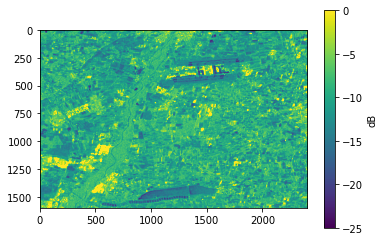

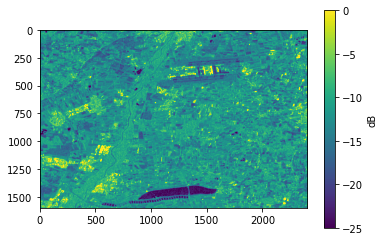

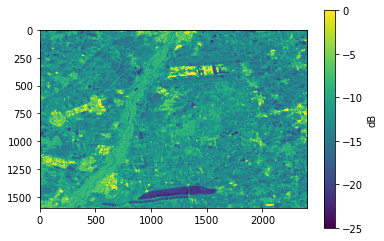

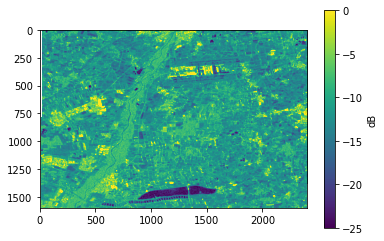

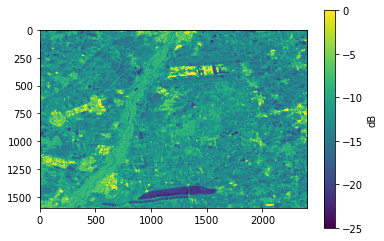

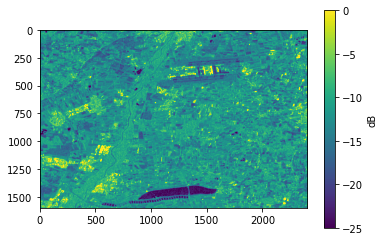

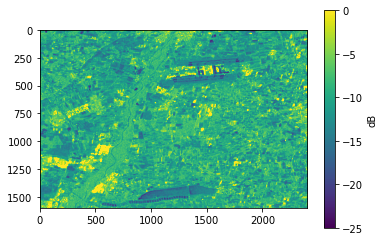

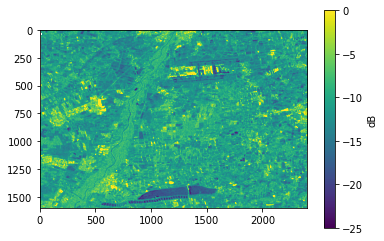

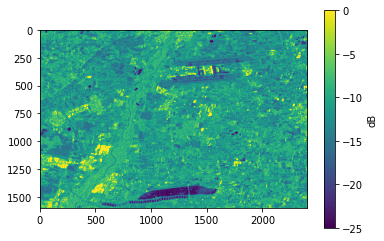

In [18]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    # Problem: border pixel might be zero or negative
    # pixel eqal or smaller than zero are set to nan
    array = np.copy(vv[x])
    array[array <= 0] = np.nan
    # plot backscatter data in dB scale
    plt.imshow(10*np.log10(array))
    cbar = plt.colorbar()
    cbar.set_label('dB')
    plt.clim(-25, 0)

interactive_plot = interactive(f, x=(0,len(vv)-1))
interactive_plot